In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import sys
import os
import math

# constants
IMAGE_SIZE = "100" # as in which input image size (50 or 100) is to be used
DESIRED_IMAGE_SIZE = 100 # as in which to use in the model, 224 for pretrained (on imagenet) CNNs
MAX_IMAGE_SIZE = 224
RANDOM_SEED = 3888 # for reproducibility
TOTAL_SAMPLE_SIZE = 1000 # how many images in tumour group + non tumour group
IMAGE_DIR = "projectdata/images/" +  IMAGE_SIZE # Image path
OUTPUT_BASE = "projectdata/images/images_" + IMAGE_SIZE + "_4fold_stratified_up_down"  # Output path

# setting up the environment
np.random.seed(RANDOM_SEED)
print(sys.version)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]


# Produce quadrants
- Split images Shila has provided into 4 quadrants based on location in original large image
    - Ignore cells whose MAX_IMAGE_SIZExMAX_IMAGE_SIZE images may overlap between quadrants **(no leakage)**
        - Note, altho taking in '100' images, these images are *actually much larger*, so the max image size we may later use in classification is used here, and *resizing must be done later*
    - Produces **4 folds** for later training
- Take a sample within each quadrant of tumour + non tumour cells for binary classfication
    - **Stratified** by cell group (immune, connective, early stage cancer, etc.), and by cell type (if immune cell group has 7 cell subtypes, each subtype should make up 1/7 of images taken)
    - Split evenly between binary groups (e.g. for immune, with 1000 total images desired from a quadrant. 1000/2 = 500 from non-tumour cells. 500/3 = ~150 from each of 3 subgroups. 150/7 from each of 7 immune cell types)
    - **Downsample** or **upsample** to meet this requirement
- Output these + visualise these as we go, **copy final images to new folder as train/test data**

## Using pre-written code "MohanGuo/datasplit.py" to split data
Adjustments:
- Using mean of values for cell boundaries, not the first value
- Dropping all images that might overlap between quadrants, by adjusting the cuttoff values for each quadrant. THESE ARE GIVEN TO Q0.
- Changed how the IMAGE_DIR + OUTPUT_BASE direcftories are generated, to allow for 50x50 pix image data to be used if desired
- Just going to keep it all in memory for now

This is Eric's code.

In [20]:
# Load coordinate files
cbr = pd.read_csv("projectdata/metadata_code/cbr.csv")  # Contains index, axis-0, axis-1
meta = pd.read_excel("projectdata/metadata_code/41467_2023_43458_MOESM4_ESM.xlsx", sheet_name=1)  # Contains cell_id and Cluster

# Merge cell ID and annotation
meta["index"] = meta.index + 1  # Ensure cell_id matches index
print(meta.head())
# image_df = pd.merge(cbr.drop_duplicates("index"), meta[["index", "Cluster"]], on="index")

# Take the average of duplicates for each row based on 'index'
print(cbr.head())
cbr_avg = cbr.groupby("index", as_index=False).mean()
print(cbr_avg.head())
image_df = pd.merge(cbr_avg, meta[["index", "Cluster"]], on="index")
print(image_df.head())

# Get image space midpoint and divide into quadrants
x_mid = image_df["axis-1"].median()
y_mid = image_df["axis-0"].median()

# Adjust midpoints to avoid data leakage
# if we take a cell, and its 224x224 neighbourhood, this might overlap with another quadrant
x_mid_high = x_mid + MAX_IMAGE_SIZE
x_mid_low = x_mid - MAX_IMAGE_SIZE
y_mid_high = y_mid + MAX_IMAGE_SIZE 
y_mid_low = y_mid - MAX_IMAGE_SIZE

def get_quadrant(row):
    if row["axis-1"] < x_mid_low and row["axis-0"] < y_mid_low:
        return "Q1"  # Top-left
    elif row["axis-1"] >= x_mid_high and row["axis-0"] < y_mid_low:
        return "Q2"  # Top-right
    elif row["axis-1"] < x_mid_low and row["axis-0"] >= y_mid_high:
        return "Q3"  # Bottom-left
    elif row["axis-1"] >= x_mid_high and row["axis-0"] >= y_mid_high:
        return "Q4"  # Bottom-right
    else:
        return "Q0"  # Cell is too close to quadrant boundaries

image_df["quadrant"] = image_df.apply(get_quadrant, axis=1)

   Barcode  UMAP_DIM1  UMAP_DIM2         Cluster  transcript_counts  \
0        1        NaN        NaN          DCIS 2                 28   
1        2        NaN        NaN          DCIS 2                 94   
2        3  -1.795124   9.981263       Unlabeled                  9   
3        4        NaN        NaN  Invasive_Tumor                 11   
4        5        NaN        NaN          DCIS 2                 48   

   x_centroid  y_centroid  gene_counts  index  
0  847.259912  326.191365           15      1  
1  826.341995  328.031830           38      2  
2  848.766919  331.743187            8      3  
3  824.228409  334.252643            9      4  
4  841.357538  332.242505           33      5  
   index        axis-0       axis-1
0      1  20795.624215  8295.401252
1      1  20793.214569  8280.106238
2      1  20789.691155  8272.472663
3      1  20782.183747  8277.228385
4      1  20778.154228  8281.963210
   index        axis-0       axis-1
0      1  20783.537959  8287.5020

## Using MohanGuo/quadrant_visualisation.ipynb to visualise quadrants

### Visualization of Cell Type Distribution in Each Fold (Q0-Q4)

Adjusted to match above, no other logical adjustments. Note this means dealing with the cell names, not file names, and only working with the df in memory (not importing files until later)

In [21]:
# # Define the images_4fold directory path
# base_dir = "projectdata/images/images_" + IMAGE_SIZE + "_4fold"

# # Check if the directory exists
# if not os.path.exists(base_dir):
#     print(f"Error: {base_dir} directory does not exist")
# else:
#     print(f"Found directory: {base_dir}")

In [22]:
cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",
    # in metadata spreadsheets, hybrid has & not 'and's, so need these keys to account for that
    "Stromal_&_T_Cell_Hybrid": "Hybrid",
    "T_Cell_&_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer 
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",
    # same as for hybrids, just underscores vs spaces 
    "DCIS 1": "Early stage cancer",
    "DCIS 2": "Early stage cancer",
    

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}

In [23]:
# # Traverse the directory and count different cell types in each fold
# fold_cell_counts = {}

# # Assume directory structure as images_4fold/[fold]/[cell_type]/[images]
# for fold in os.listdir(base_dir):
#     fold_path = os.path.join(base_dir, fold)
    
#     if os.path.isdir(fold_path):
#         cell_counts = {}
        
#         for cell_type in os.listdir(fold_path):
#             cell_type_path = os.path.join(fold_path, cell_type)
            
#             if os.path.isdir(cell_type_path):
#                 # Calculate the number of images of this cell type
#                 image_count = len([f for f in os.listdir(cell_type_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
#                 cell_counts[cell_type] = image_count
        
#         fold_cell_counts[fold] = cell_counts

# Count different cell types in each fold using the dataframe 'image_df'
fold_cell_counts = {}

# Group by quadrant and Cluster to count the number of occurrences
grouped_df = image_df.groupby(['quadrant', 'Cluster']).size().reset_index(name='Count')

# Populate the fold_cell_counts dictionary
for _, row in grouped_df.iterrows():
    fold = row['quadrant']
    cell_type = row['Cluster']
    count = row['Count']
    
    if fold not in fold_cell_counts:
        fold_cell_counts[fold] = {}
    
    fold_cell_counts[fold][cell_type] = count

In [24]:
# Convert the data to DataFrame format for easier visualization
data_rows = []
for fold, cell_types in fold_cell_counts.items():
    for cell_type, count in cell_types.items():
        data_rows.append({'Fold': fold, 'Cell Type': cell_type, 'Count': count})

summary_df = pd.DataFrame(data_rows)

In [25]:
# Add the cell group to the DataFrame based on cell_group_map
summary_df['Cell Group'] = summary_df['Cell Type'].map(cell_group_map)

# Check if there are any NaN values in 'Cell Group' (indicating missing mappings)
if summary_df['Cell Group'].isnull().any():
    missing_types =summary_df[summary_df['Cell Group'].isnull()]['Cell Type'].unique()
    print("Warning: The following cell types do not have a group mapping:")
    print(missing_types)

# Aggregate counts by fold and cell group
group_counts = summary_df.groupby(['Fold', 'Cell Group'])['Count'].sum().reset_index()

### Cell Group Distribution For Each Quadrant

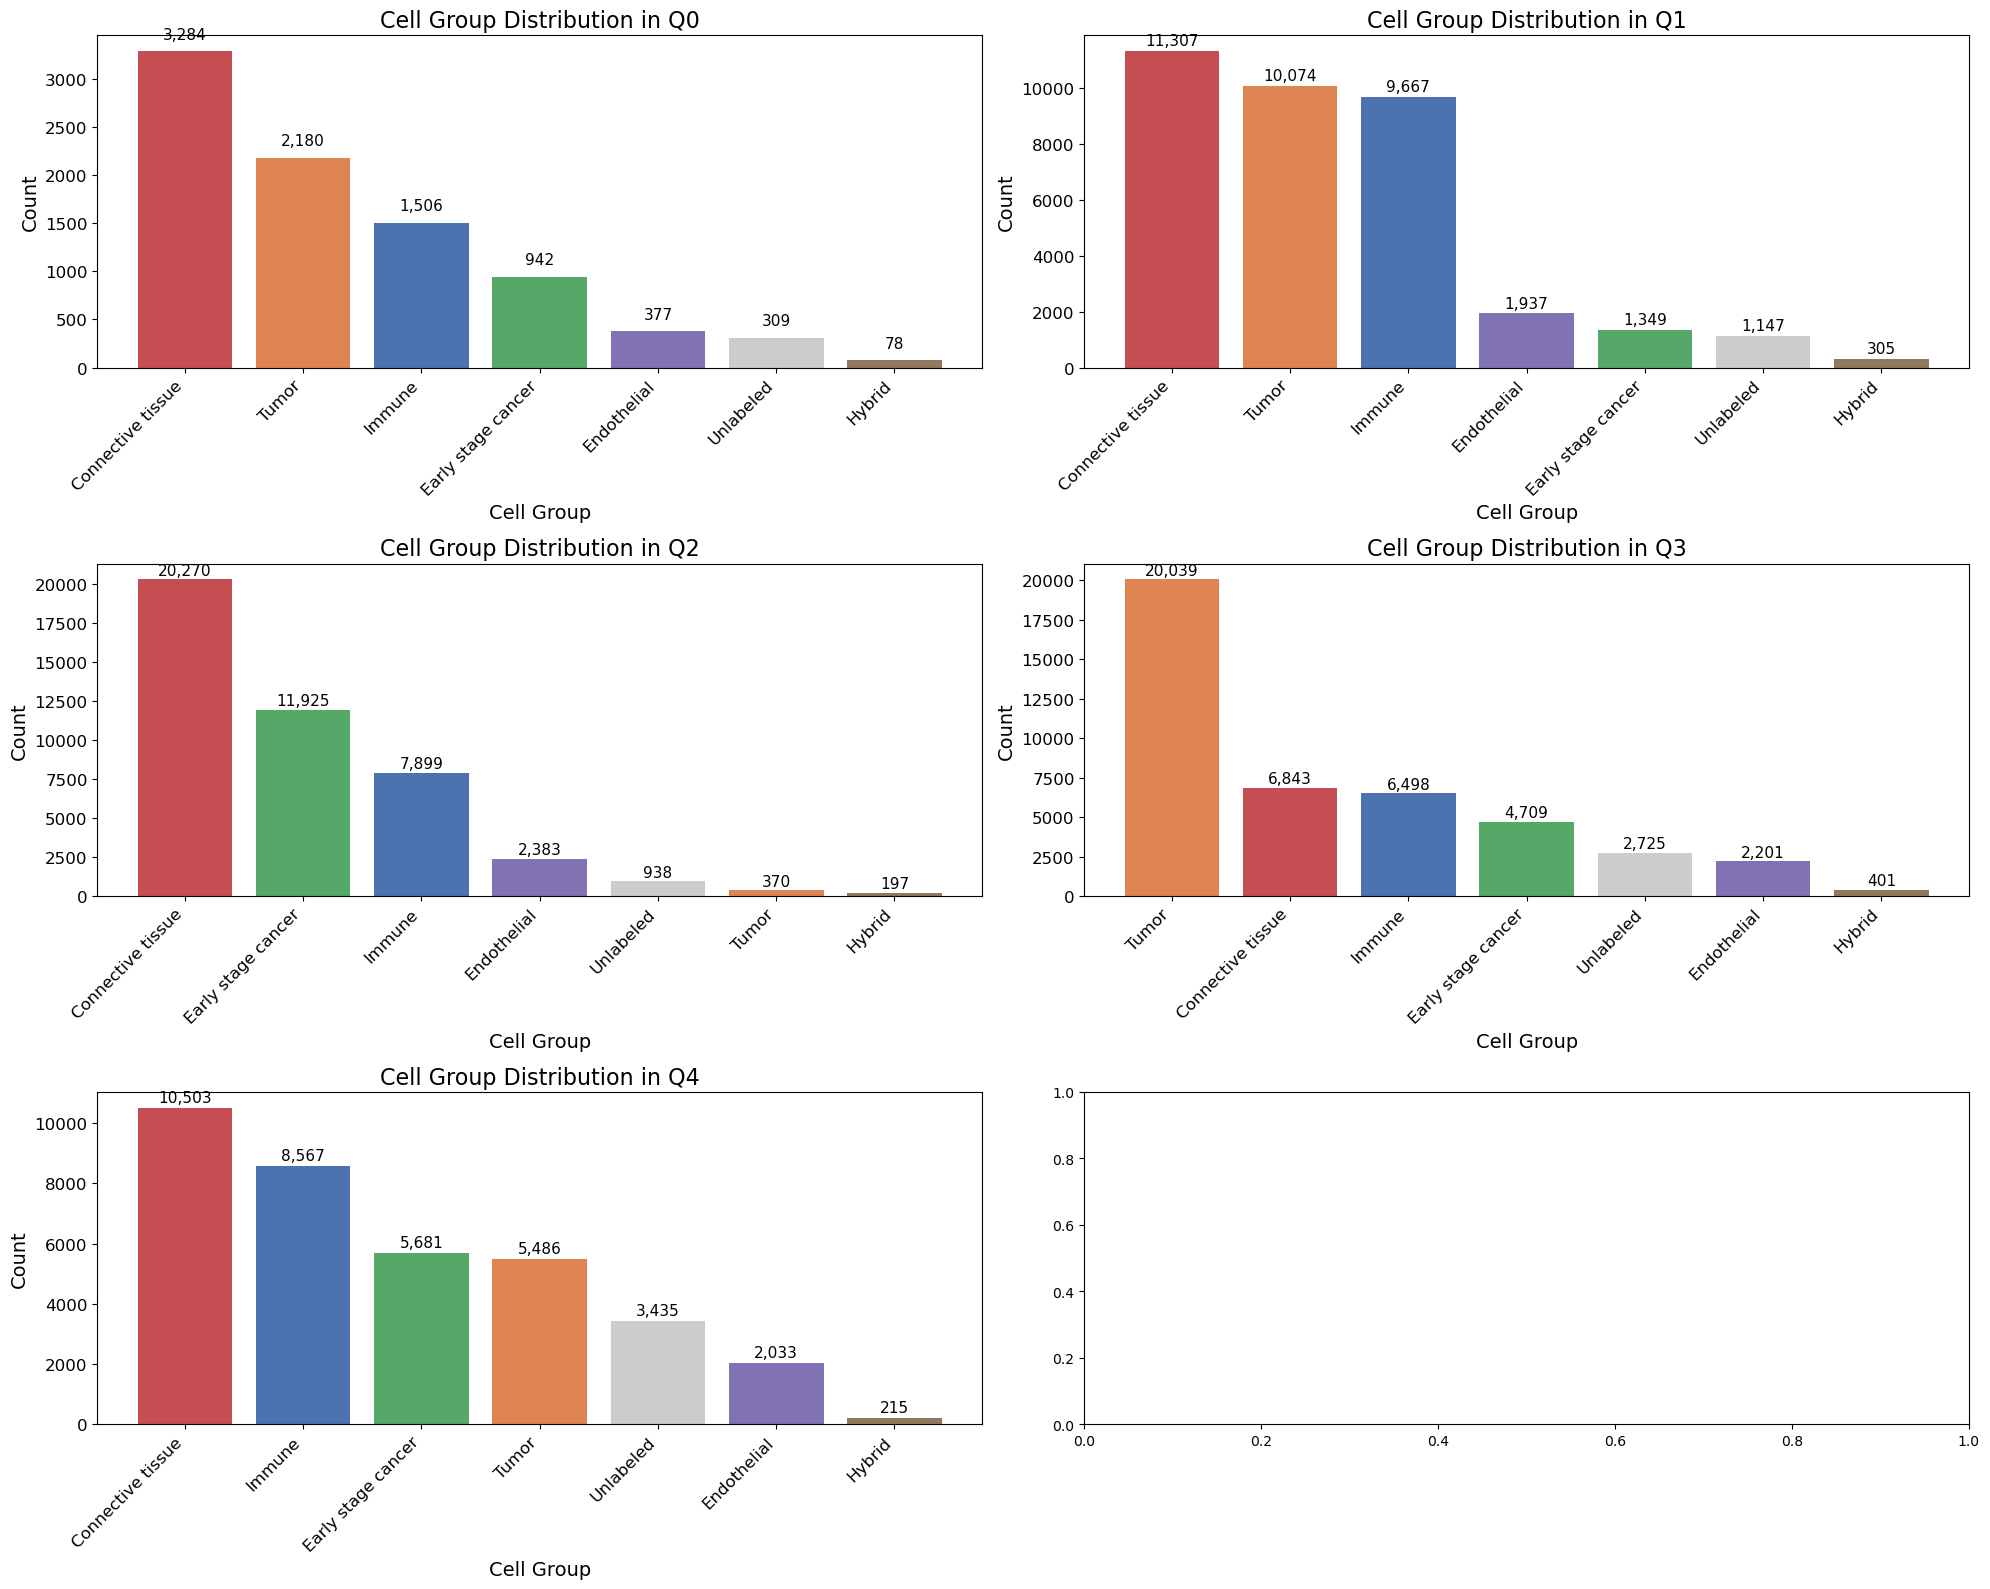

In [26]:
# Create separate plots for each fold (Q1-Q4) showing cell groups
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()

folds = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4']
colors = {
    'Immune': '#4C72B0',
    'Tumor': '#DD8452',
    'Early stage cancer': '#55A868',
    'Connective tissue': '#C44E52',
    'Endothelial': '#8172B3',
    'Hybrid': '#937860',
    'Unlabeled': '#CCCCCC'
}

for i, fold in enumerate(folds):
    # Filter data for the current fold
    fold_data = group_counts[group_counts['Fold'] == fold]
    
    # Sort by count for better visualization
    fold_data = fold_data.sort_values('Count', ascending=False)
    
    # Create the bar plot with custom colors
    bars = axes[i].bar(fold_data['Cell Group'], fold_data['Count'], color=[colors.get(group, '#CCCCCC') for group in fold_data['Cell Group']])
    
    # Set title and labels
    axes[i].set_title(f'Cell Group Distribution in {fold}', fontsize=16)
    axes[i].set_xlabel('Cell Group', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    
    # Add count values on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=11)
    
    # Set tick parameters
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### Comparing Cell Distribution Across Folds

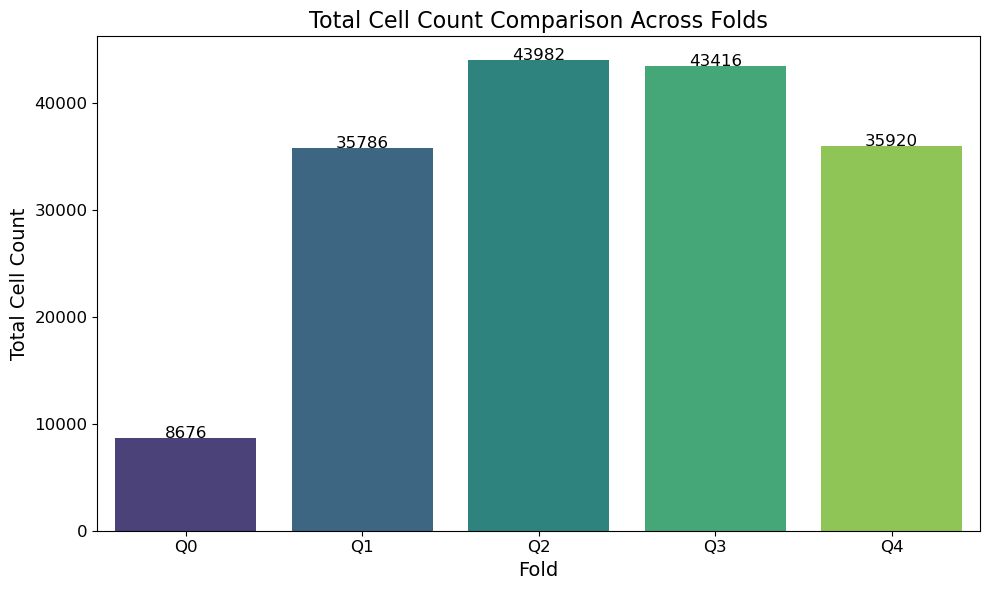

In [27]:
# Calculate the total number of cells in each fold
fold_totals = summary_df.groupby('Fold')['Count'].sum().reset_index()

# Create a bar chart to compare the total number of cells in each fold
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Count', hue='Fold', data=fold_totals, palette='viridis', legend=False)
plt.title('Total Cell Count Comparison Across Folds', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Total Cell Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numerical labels above each bar
for i, v in enumerate(fold_totals['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Trying to run stratified down-sampling + upsampling (Q1-Q4, no Q0), and then visualising these, using binary classes
Procedure
- go over each fold
- go over each cell type, stratified with cell group + cell type, try get TOTAL_SAMPLE_SIZE/2 (upsampling if required) from each of tumour + non tumour
    get  TOTAL_SAMPLE_SIZE/2 from each group, further trying to make sure strafified by subgroup
    say non-tumour, we want 2000 images. 3 sub groups (immune, endo, connective), so 666 from each. immune has 7 subypes, so 666/7 from each.
- visualise these

Note, this involves 'sampling' from image_df, and then reproducing grouped/summary dfs based on this.

In [28]:
print(summary_df.head())

# drop Q0 (this is just for cells to drop)
summary_df = summary_df[summary_df["Fold"] != "Q0"]

# drop hybrid + unlabelled cell groups
summary_df = summary_df[~summary_df["Cell Group"].isin(["Hybrid", "Unlabeled"])]

print(summary_df.head())
print(image_df.head())


  Fold     Cell Type  Count          Cell Group
0   Q0       B_Cells    212              Immune
1   Q0  CD4+_T_Cells    307              Immune
2   Q0  CD8+_T_Cells    326              Immune
3   Q0        DCIS 1    512  Early stage cancer
4   Q0        DCIS 2    430  Early stage cancer
   Fold     Cell Type  Count          Cell Group
20   Q1       B_Cells   1564              Immune
21   Q1  CD4+_T_Cells   2751              Immune
22   Q1  CD8+_T_Cells   2123              Immune
23   Q1        DCIS 1     13  Early stage cancer
24   Q1        DCIS 2   1336  Early stage cancer
   index        axis-0       axis-1         Cluster quadrant
0      1  20783.537959  8287.502067          DCIS 2       Q3
1      2  20780.058221  8227.236189          DCIS 2       Q3
2      3  20770.997192  8293.148625       Unlabeled       Q3
3      4  20764.482893  8224.974469  Invasive_Tumor       Q3
4      5  20770.467129  8271.501109          DCIS 2       Q3


In [29]:
# manually calculated from above
group_sizes = {"Immune": 7, "Hybrid": 2, "Tumor": 2, "Early stage cancer": 2, "Connective tissue": 4, "Endothelial":1, "Unlabeled":1}

# NOTE - HYRBID + UNLABELLED SHOULD NOT BE CONSIDERED HERE
group_to_binary_map = {"Immune": "Non-Tumor", "Tumor": "Tumor", "Early stage cancer": "Tumor", "Connective tissue": "Non-Tumor", "Endothelial":"Non-Tumor"}

summary_df['binary_group'] = summary_df['Cell Group'].map(group_to_binary_map)

image_df['binary_group'] = image_df['Cluster'].map(cell_group_map).map(group_to_binary_map)

In [30]:
# go over each fold
# go over each cell type, and downsample/upsample as reqd from each one (ignoring hybrid + unlabelled)
# Initialize a list to store sampled data
stratified_down_up_data = []

# Iterate over each fold
for fold in summary_df['Fold'].unique():
    fold_data = summary_df[summary_df['Fold'] == fold]
    fold_image_data = image_df[image_df['quadrant'] == fold]
        
    # Sample data for each cell type in this fold
    for cell_type in fold_data['Cell Type'].unique():
        # find the desired number of images from this fold

        binary_group = group_to_binary_map[cell_group_map[cell_type]]
        # Count the number of subgroups in the binary group we are looking at
        count_sub_groups = sum(1 for k, v in group_to_binary_map.items() if v == binary_group)
        # divide total images per binary group (2000 per), then by numbe r of subgroups (say non-tumour, then 3 subgroups giving ~666), then by number of types in subgroup (say immune, 7 types, giving ~90 or wtvr)
        desired_count = math.ceil(((TOTAL_SAMPLE_SIZE/2)/count_sub_groups)/group_sizes[cell_group_map[cell_type]])
        
        cell_type_data = fold_image_data[fold_image_data['Cluster'] == cell_type]
        
        if len(cell_type_data) > desired_count:
            stratified_down_up_data.append(cell_type_data.sample(n=desired_count, random_state=RANDOM_SEED, replace=False))
        else:
            stratified_down_up_data.append(cell_type_data.sample(n=desired_count, random_state=RANDOM_SEED, replace=True))

        

# Combine all sampled data into a single DataFrame
stratified_down_up_df = pd.concat(stratified_down_up_data)  
print(stratified_down_up_df.head())



       index        axis-0        axis-1  Cluster quadrant binary_group
39231  39232   8705.027660   6953.415756  B_Cells       Q1    Non-Tumor
77300  77301  13977.941122  12625.107412  B_Cells       Q1    Non-Tumor
79635  79636  13044.505911  10670.059326  B_Cells       Q1    Non-Tumor
40667  40668   9186.093940   6411.250621  B_Cells       Q1    Non-Tumor
35626  35627  11505.999442   6408.227130  B_Cells       Q1    Non-Tumor


### Revisualise produce data

In [31]:
# Count different cell types in each fold using the dataframe 'downsampled_df'
fold_cell_counts = {}

# Group by quadrant and Cluster to count the number of occurrences
grouped_df2 = stratified_down_up_df.groupby(['quadrant', 'Cluster']).size().reset_index(name='Count')

# Populate the fold_cell_counts dictionary
for _, row in grouped_df2.iterrows():
    fold = row['quadrant']
    cell_type = row['Cluster']
    count = row['Count']
    
    if fold not in fold_cell_counts:
        fold_cell_counts[fold] = {}
    
    fold_cell_counts[fold][cell_type] = count

# Convert the data to DataFrame format for easier visualization
data_rows = []
for fold, cell_types in fold_cell_counts.items():
    for cell_type, count in cell_types.items():
        data_rows.append({'Fold': fold, 'Cell Type': cell_type, 'Count': count})

summary_df2 = pd.DataFrame(data_rows)
print(summary_df2.head())

# Add the cell group to the DataFrame based on cell_group_map
summary_df2['Cell Group'] = summary_df2['Cell Type'].map(cell_group_map)

# Check if there are any NaN values in 'Cell Group' (indicating missing mappings)
if summary_df2['Cell Group'].isnull().any():
    missing_types =summary_df2[summary_df2['Cell Group'].isnull()]['Cell Type'].unique()
    print("Warning: The following cell types do not have a group mapping:")
    print(missing_types)

# Aggregate counts by fold and cell group
group_counts2 = summary_df2.groupby(['Fold', 'Cell Group'])['Count'].sum().reset_index()
print(group_counts2.head())

  Fold     Cell Type  Count
0   Q1       B_Cells     24
1   Q1  CD4+_T_Cells     24
2   Q1  CD8+_T_Cells     24
3   Q1        DCIS 1    125
4   Q1        DCIS 2    125
  Fold          Cell Group  Count
0   Q1   Connective tissue    168
1   Q1  Early stage cancer    250
2   Q1         Endothelial    167
3   Q1              Immune    192
4   Q1               Tumor    250


#### Within groups

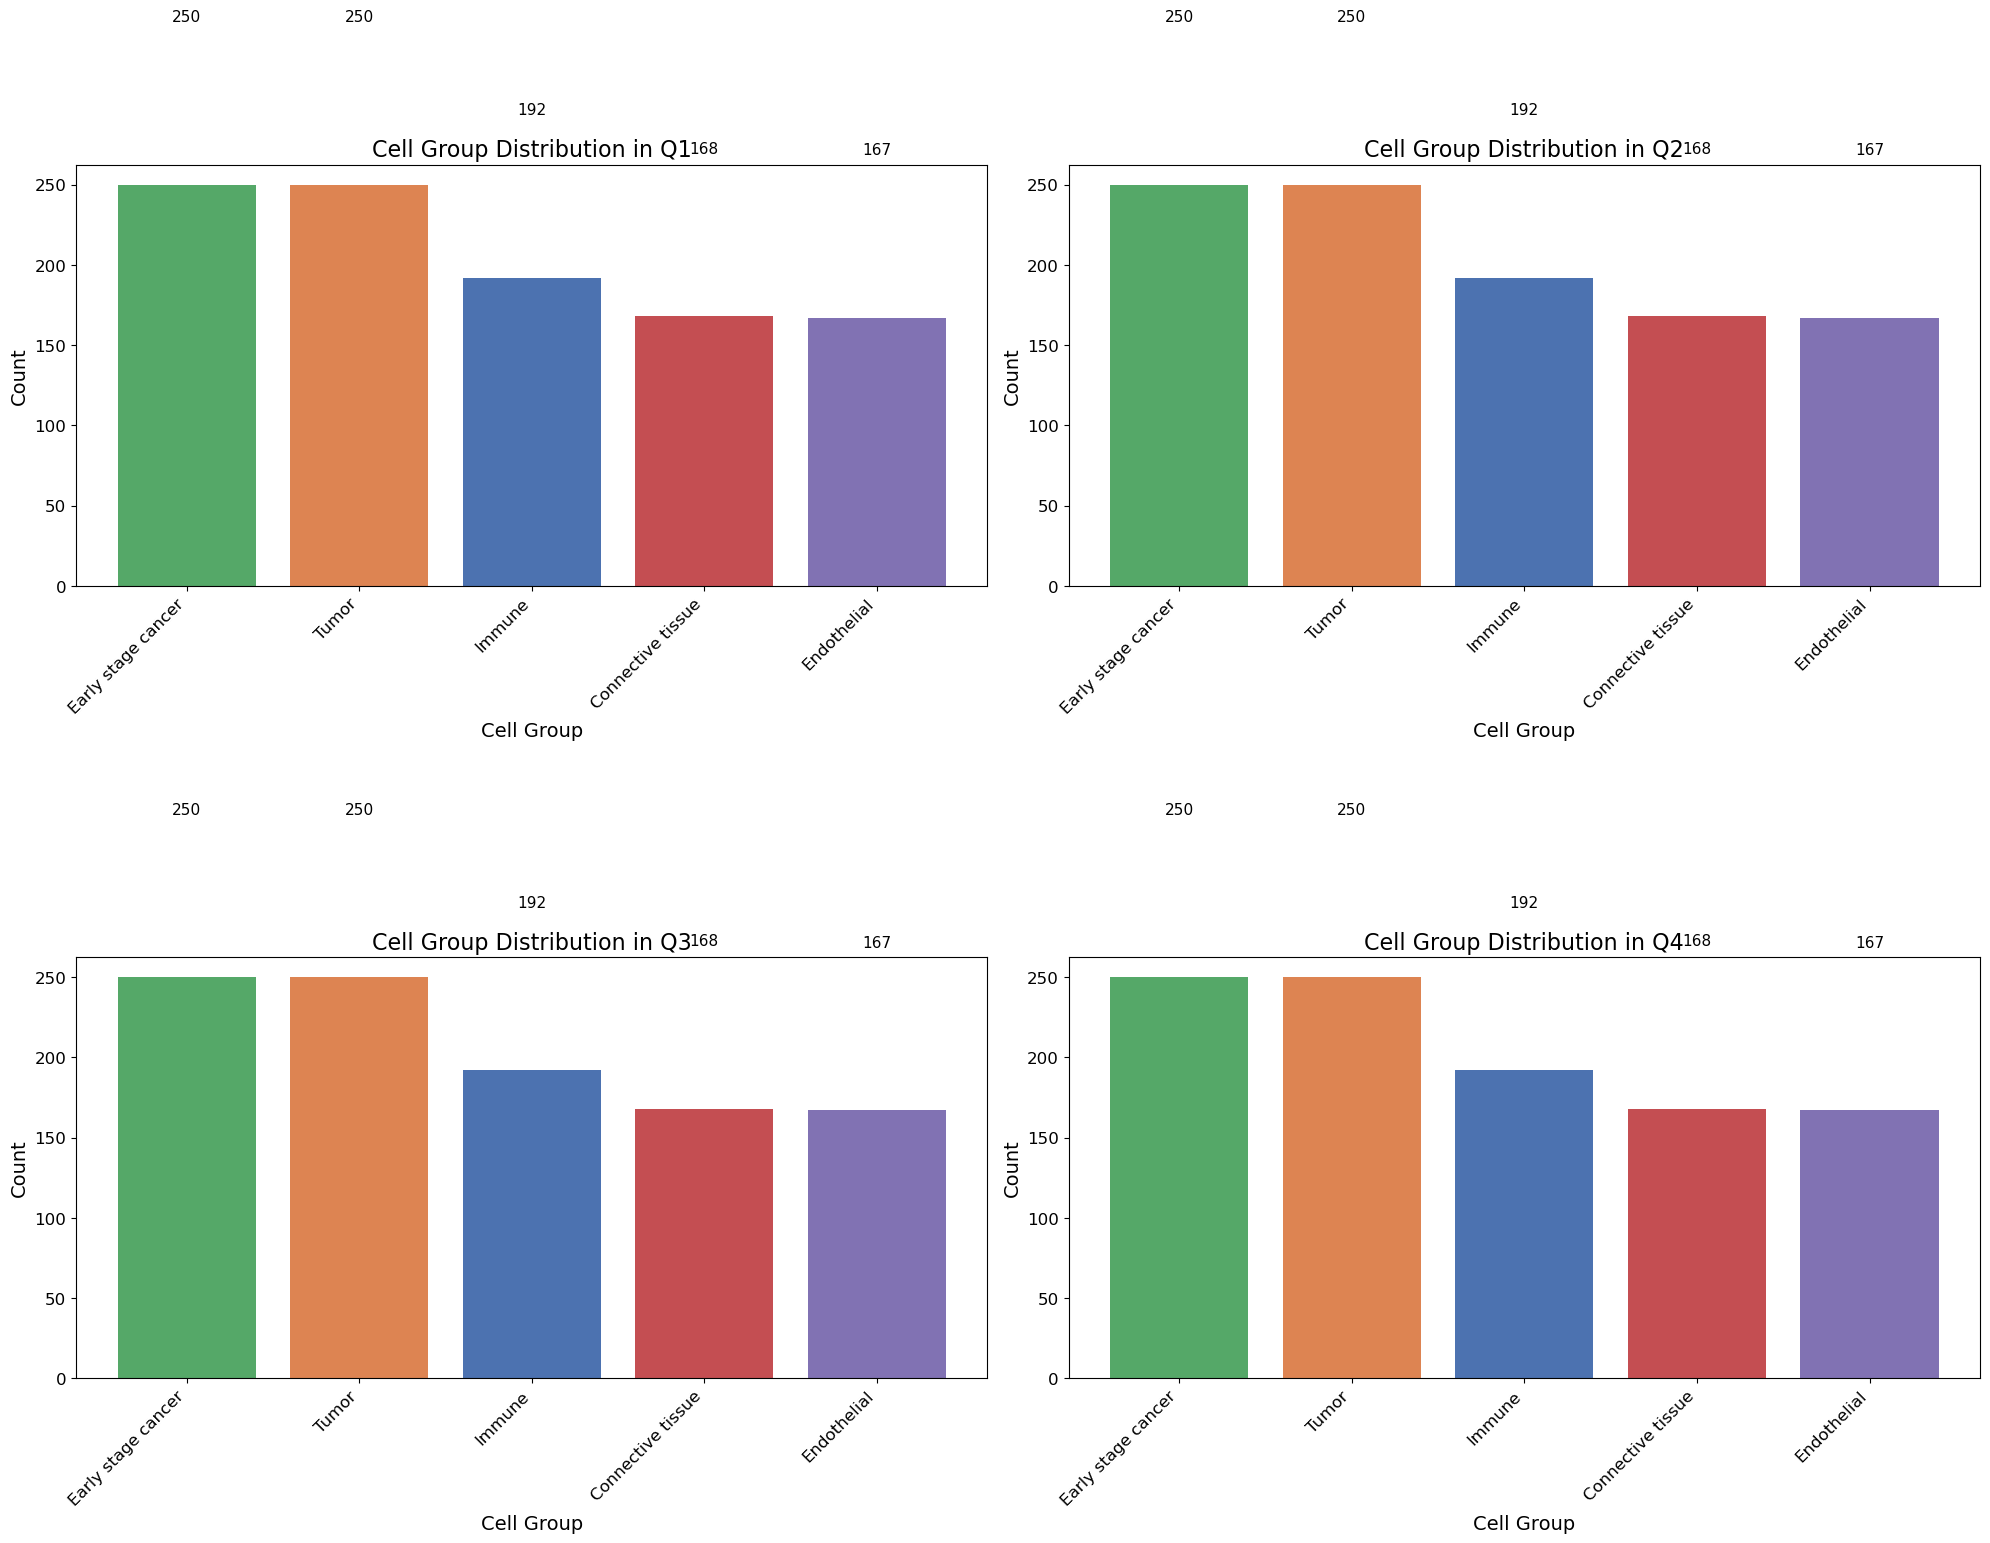

In [32]:
# Create separate plots for each fold (Q1-Q4) showing cell groups
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

folds = ['Q1', 'Q2', 'Q3', 'Q4']
colors = {
    'Immune': '#4C72B0',
    'Tumor': '#DD8452',
    'Early stage cancer': '#55A868',
    'Connective tissue': '#C44E52',
    'Endothelial': '#8172B3'
}

for i, fold in enumerate(folds):
    # Filter data for the current fold
    fold_data = group_counts2[group_counts2['Fold'] == fold]
    
    # Sort by count for better visualization
    fold_data = fold_data.sort_values('Count', ascending=False)
    
    # Create the bar plot with custom colors
    bars = axes[i].bar(fold_data['Cell Group'], fold_data['Count'], color=[colors.get(group, '#CCCCCC') for group in fold_data['Cell Group']])
    
    # Set title and labels
    axes[i].set_title(f'Cell Group Distribution in {fold}', fontsize=16)
    axes[i].set_xlabel('Cell Group', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    
    # Add count values on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontsize=11)
    
    # Set tick parameters
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

#### Accross distributions

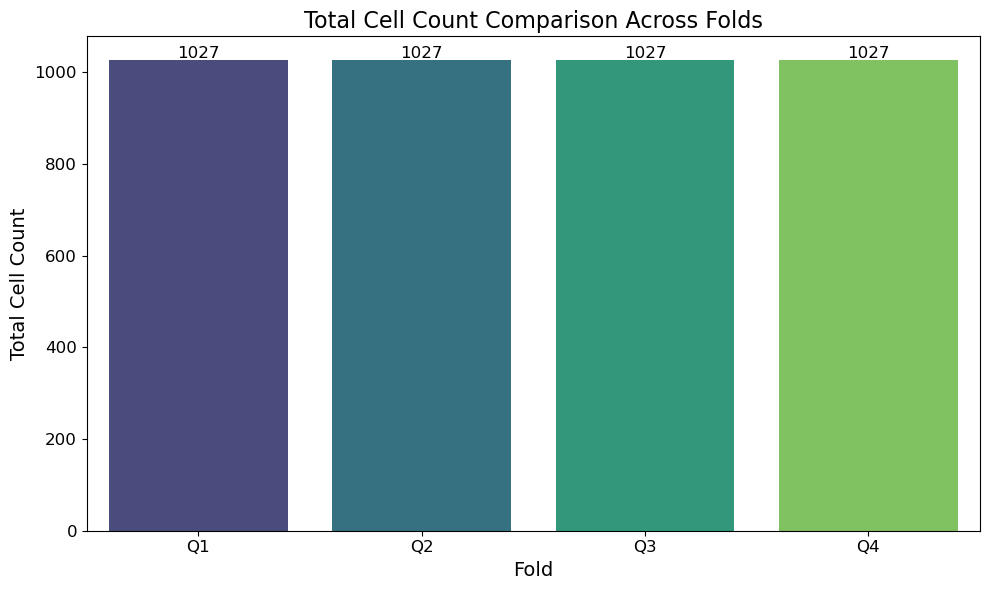

In [33]:
# Calculate the total number of cells in each fold
fold_totals = summary_df2.groupby('Fold')['Count'].sum().reset_index()

# Create a bar chart to compare the total number of cells in each fold
plt.figure(figsize=(10, 6))
sns.barplot(x='Fold', y='Count', hue='Fold', data=fold_totals, palette='viridis', legend=False)
plt.title('Total Cell Count Comparison Across Folds', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Total Cell Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add numerical labels above each bar
for i, v in enumerate(fold_totals['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Output images to subfolders

In [36]:
# Copy images to corresponding quadrant subfolders

for _, row in stratified_down_up_df.iterrows():
    
    cluster = row["Cluster"].replace("&", "and").replace(" ", "_")
    quadrant = row["quadrant"]

    # TO OUTPUT INTO FOLDERS BASED ON CELL TYPE
    # dst_folder = os.path.join(OUTPUT_BASE, quadrant, cluster)
    # TO OUTPUT INTO FOLDERS BASED ON BINARY GROUP
    dst_folder = os.path.join(OUTPUT_BASE, quadrant, row["binary_group"])

    src_path = os.path.join(IMAGE_DIR, cluster, f"cell_{row['index']}_100.png")
    os.makedirs(dst_folder, exist_ok=True)
    dst_path = os.path.join(dst_folder, f"cell_{row['index']}_100.png")
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        # NOTE -> WILL SIMPLY SKIP _10, rather then adjusting sample based on this
        print(f"{src_path} not found. might be _10 not _100 pixel image in original data.")